# About

This notebook helps you to create your first solution and the first submisson file. Fill free to modify this notebook to create you own solution.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [ ]:
# Change this according to your directory preferred setting
path_to_train = "../input/train_1"

# This event is in Train_1
event_prefix = "event000001000"

# Reading single event

In [ ]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [ ]:
hits.head()

# Track pattern recognition

In this example the track pattern recognition is solved as a classification problem. In this case each track corresponds to one class. We train a kNN classifier to learn patterns of tracks in training events as it is shown in the following figure:

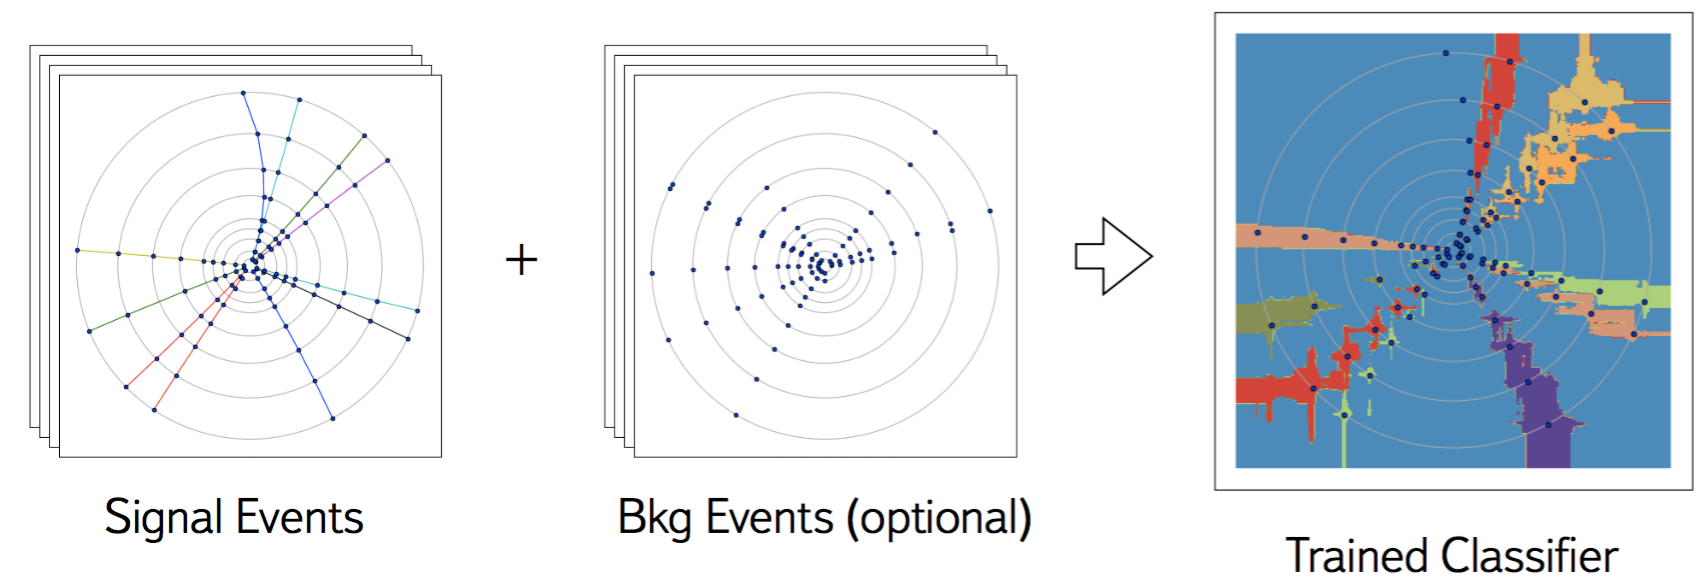

Different colors in the last figure correspond to different classes learnt by the classifier. This classifier is used to recognize tracks in other events that are not used for the training. All hits that fall into a class are considered as a recognized track. This idea is shown below:

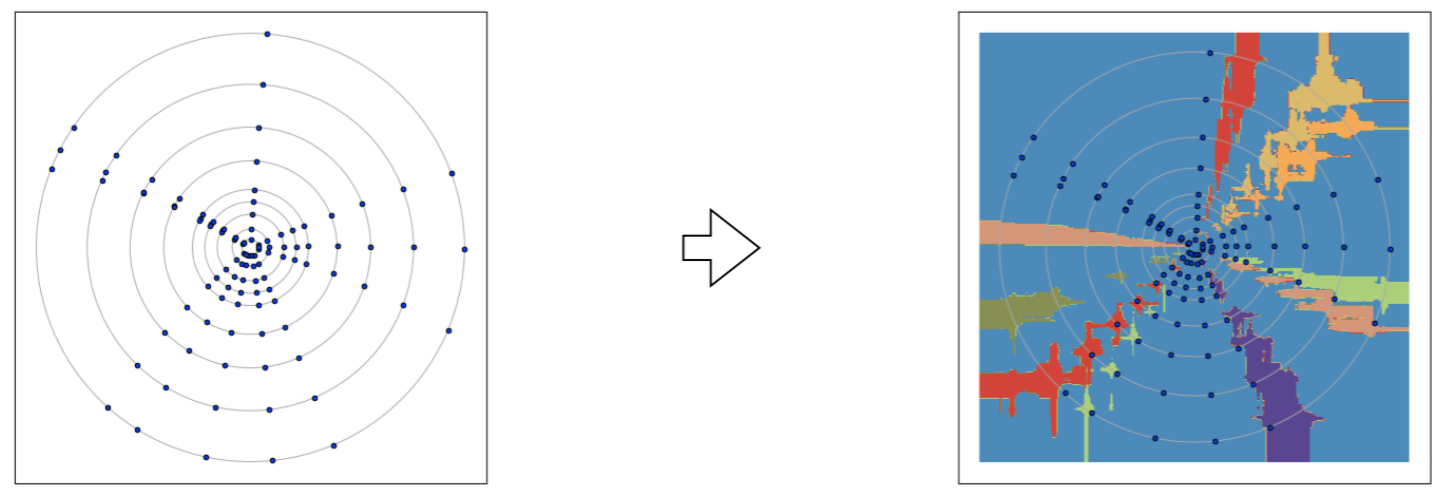

One classifier recognizes just few tracks. But combining several such classifiers can help to find more tracks. Fill free to modify this example.

### Train

Lets combine several events into single sample to train the classifier.

In [ ]:
def get_training_sample(path_to_data, event_names):

    events = []
    track_id = 0

    for name in event_names:

        # Read an event
        hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

        # Generate new vector of particle id
        particle_ids = truth.particle_id.values
        particle2track = {}
        for pid in np.unique(particle_ids):
            particle2track[pid] = track_id
            track_id += 1
        hits['particle_id'] = [particle2track[pid] for pid in particle_ids]

        # Collect hits
        events.append(hits)

    # Put all hits into one sample with unique tracj ids
    data = pd.concat(events, axis=0)

    return data

In [ ]:
start_event_id = 1000
n_train_samples = 5
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

In [ ]:
train_data.head()

Then, train the classifier using this sample. Notice that data preprocessing is included into the training procedure.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

class Clusterer(object):
    
    def __init__(self):
        self.classifier = None
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    def fit(self, hits):
        
        X = self._preprocess(hits)
        y = hits.particle_id.values
        
        self.classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        self.classifier.fit(X, y)
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        labels = self.classifier.predict(X)
        
        return labels

In [ ]:
model = Clusterer()
model.fit(train_data)

### Test

Use the trained classifier to predict labels of hits in a new event.

In [ ]:
path_to_event = os.path.join(path_to_train, "event0000{:05d}".format(start_event_id + n_train_samples + 1))
hits, cells, particles, truth = load_event(path_to_event)

In [ ]:
%%time
# Warning: it takes about 30s per one event
labels = model.predict(hits)

In [ ]:
labels

# Score

Calculate quality of the track pattern recognition for one event.

In [ ]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [ ]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [ ]:
print("Your score: ", score)

# Recognize tracks in all events of a dataset

In this example, the dataset is the whole training set. This may take a very long time. To run on only a subset, use

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

**Warning:** it takes about 30s per one event

In [ ]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=1000, nevents=5):
        
    # Track pattern recognition
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

# Submission

Create a submission file.

**Warning:** it takes about 30s per one event

In [ ]:
path_to_test = "../input/test"
test_dataset_submissions = []

create_submission = False # True for submission 

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('submission.csv.gz', index=False, compression='gzip')